In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy
from scipy import stats
from matplotlib import pyplot as plt

   # Creating Classes

   **Road data handling class**

In [2]:
class Road_Features():
    """
    This class reads the csvs of Road data , clean and returen the organized dataFrames
    """
    def __init__(self):
        self.Signal_Handling()
  
        
    
        self.Speed_Handling()
        self.Camera_Handling()
        self.Incidents_Handling()
        self.Sign_Handling()
        self.Volume_Handling()
        

    def Speed_Handling(self):
        self.speed_limit=pd.read_csv('Speed_Limits.csv')
        
        self.speed_limit.rename(columns={'STREET_NAME':'Location','SPEED':'Speed','multiline':'Coordinates','CREATED_DT':'Date'},inplace=True)
        coord=self.speed_limit['Coordinates'].str.split(expand=True)
        
        for i in range(len(coord.columns)):
            if(i>0):
                coord[i]= coord[i].str.strip(')(,')
        coord.drop(columns=0,inplace=True)
        self.speed_limit['Date']=pd.to_datetime(self.speed_limit['Date'])
        self.speed_limit['Year']=pd.DatetimeIndex(self.speed_limit['Date']).year
        self.speed_limit=self.speed_limit[['Year','Speed']]
        self.speed_limit=pd.merge(self.speed_limit,coord,left_index=True,right_index=True)
        self.speed_limit=self.speed_limit.loc[self.speed_limit['Year']<=2018]
    def Camera_Handling(self):
        self.cameras=pd.read_csv('Traffic_Camera_Locations.csv')
        self.cameras=self.cameras[['longitude','latitude']]
    def Incidents_Handling(self):
        self.incidents=pd.read_csv('Traffic_Incidents.csv')
        self.incidents.rename(columns={'INCIDENT INFO':'Location','START_DT':'Date'},inplace=True)
        self.incidents['Date']=pd.to_datetime(self.incidents['Date'])
        self.incidents['Year']=pd.DatetimeIndex(self.incidents['Date']).year
        self.incidents=self.incidents[['Location','Year','Longitude','Latitude','Count']]
        self.incidents=self.incidents.loc[self.incidents['Year']==2018]
        self.incidents=self.incidents.groupby('Location').sum().reset_index()
        self.incidents['Longitude']=self.incidents['Longitude']/self.incidents['Count']
        self.incidents['Latitude']=self.incidents['Latitude']/self.incidents['Count']
        self.incidents['Year']=self.incidents['Year']/self.incidents['Count']
        self.incidents.to_csv('organzied_incidents.csv')
    def Signal_Handling(self):
        self.signals=pd.read_csv('Traffic_Signals.csv')
        self.signals.rename(columns={'INSTDATE':'Date','INT_TYPE':'Signal Type','latitude':'Latitude',\
                                     'longitude':'Longitude'},inplace=True)
        self.signals['Intersection']=self.signals['FIRSTROAD']+' & '+self.signals['SECONDROAD']
        self.signals['Date']=pd.to_datetime(self.signals['Date'])
        self.signals['Year']=pd.DatetimeIndex(self.signals['Date']).year
        self.signals['Signal Type']=self.signals['Signal Type'].astype(str)
        self.signals=self.signals[['Intersection','Signal Type','Year','Longitude','Latitude','Count']]
        
        self.signals=self.signals.loc[self.signals['Year']<=2018]
        self.signals=self.signals.groupby('Intersection').sum().reset_index()
        
        self.signals['Longitude']=self.signals['Longitude']/self.signals['Count']
        self.signals['Latitude']=self.signals['Latitude']/self.signals['Count'] 
        self.signals['Year']=self.signals['Year']/self.signals['Count'] 
        
    def Sign_Handling(self):
        self.signs=pd.read_csv('Traffic_Signs.csv')
        self.signs.rename(columns={'BLADE_TYPE':'Type','INSTDATE':'Date'},inplace=True)
        
        self.signs['Date']=pd.to_datetime(self.signs['Date'])
        self.signs['Year']=pd.DatetimeIndex(self.signs['Date']).year
        self.signs['Count']=1
        self.signs=self.signs[['Type','Year','POINT','Count']]
        self.signs=self.signs.loc[(self.signs['Type']=='Pedestrian') | (self.signs['Type']=='Yield') | (self.signs['Type']=='Stop') | (self.signs['Type']=='Bicycle / Pathway') | (self.signs['Type']=='Speed') | (self.signs['Type']=='School') | (self.signs['Type']=='Playground')]
        self.signs=self.signs.groupby('POINT').sum().reset_index()
        self.signs['Year']=self.signs['Year']/self.signs['Count']
        self.signs=self.signs.loc[self.signs['Year']<=2018]
        coord=self.signs['POINT'].str.split(expand=True)
#         
        for i in range(len(coord.columns)):
            
            if (i>0):
                coord[i]= coord[i].str.strip(',()')

        coord.drop(columns=0,inplace=True)
        self.signs.drop(columns='POINT',inplace=True)
        self.signs=pd.merge(self.signs,coord,left_index=True,right_index=True)

    def Volume_Handling(self):
        self.volume=pd.read_csv('Traffic_Volumes_for_2018.csv')
        self.volume.rename(columns={'YEAR':'Year','SECNAME':'Location','VOLUME':'Volume'},inplace=True)
        coord=self.volume['multilinestring'].str.split(expand=True)
        for i in range(len(coord.columns)):
            
            if (i>0):
                coord[i]= coord[i].str.strip(',()')
        coord.drop(columns=0,inplace=True)
        self.volume=self.volume[['Year','Location','Volume']]
        self.volume=pd.merge(self.volume,coord,left_index=True,right_index=True)
    
    def get_Speed(self):
        return self.speed_limit
    def get_Camera(self):
        return self.cameras
    def get_Incident(self):
        return self.incidents
    def get_Signal (self):
        return self.signals
    def get_Sign (self):
        return self.signs
    def get_Volume(self):
        return self.volume
        

**Weather data Class**

In [3]:
class Weather_Features():
        
    def download_weather_data(self):
        self.url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={timeframe}&submit=Download+Data"
        self.daily_avg=pd.DataFrame()
        for i in range (1,13):
            self.url = self.url_template.format(station = 50430, year=2018, month=i, timeframe = 1)
            self.weather_data = pd.read_csv(self.url, index_col='Date/Time', parse_dates=True)
            self.weather_data.columns = [col.replace('\xb0', '') for col in self.weather_data.columns]
            self.data_df = pd.DataFrame(self.weather_data)
            self.data_df = self.data_df[['Temp (C)','Visibility (km)']]
            self.data_df=self.data_df.resample('D').mean()
            self.daily_avg=self.daily_avg.append(self.data_df)
        return self.daily_avg
    def get_Stats(self):
        return self.daily_avg.describe().reset_index()
        


**Map Class**

In [4]:
class Map ():
    """
    this class generates the map with boundary and gridlines, also generate the grid coordinates
    Todo- add markers for each grid to popup stats per grid
    """
    def __init__(self):
        self.boundary=pd.read_csv('City_Boundary_layer.csv')
        self.boundary=self.boundary['the_geom'].str.split(expand=True)
        
        
        for i in range(len(self.boundary.columns)):
            if(i>0):
                self.boundary[i]= self.boundary[i].str.strip(')(,')
        self.boundary.drop(columns=0,inplace=True)
        self.Boundary()
        self.draw_Boundary()
        self.draw_Grid()
        self.generate_Grid_Coord()
        
    def Boundary(self):
       
        df=pd.DataFrame(columns=['Lat','Long'])
        for i in range(0,len(self.boundary.columns),2):
            if(i+1)<len(self.boundary.columns):
                df = df.append({'Long':self.boundary.iloc[0,(i)],'Lat':self.boundary.iloc[0,(i+1)]}, ignore_index=True)
            else:
                break
        self.min_lat=float(df['Lat'].min())
        self.max_lat=float(df['Lat'].max())
        self.min_long=float(df['Long'].min())
        self.max_long=float(df['Long'].max())
#         print(self.min_lat,self.max_long)
#         print(self.min_lat,self.min_long)
#         print(self.max_lat,self.min_long)
#         print(self.max_lat,self.max_long)
    def draw_Boundary(self):
        self.m=folium.Map(location=[51.048615,-114.070847],zoom_start=10)
        cord=[[self.min_lat,self.max_long],[self.min_lat,self.min_long],
              [self.max_lat,self.min_long],[self.max_lat,self.max_long],[self.min_lat,self.max_long]]
        
        folium.PolyLine(cord,color='blue').add_to(self.m)
#         line=folium.vector_layers.PolyLine(self.boundary_coordinates,popup='<b>boundary</b>',\
#                                      tooltip='boundary',color='blue',weight=10).add_to(f1)
        
        
#         print('hter')
#         display(m)
    def draw_Grid(self):
        self.diff_long=(self.max_long-self.min_long)/10
        
        self.diff_lat=(self.max_lat-self.min_lat)/10
        for i in range(10):
            cord=[[self.min_lat,(self.max_long-self.diff_long*i)],[self.max_lat,(self.max_long-self.diff_long*i)]]
            line=folium.vector_layers.PolyLine(cord,color='blue').add_to(self.m)
        for i in range(10):
            cord=[[(self.max_lat-self.diff_lat*i),self.max_long],[(self.max_lat-self.diff_lat*i),self.min_long]]
            line=folium.vector_layers.PolyLine(cord,color='blue').add_to(self.m)
        
#         folium.Marker(location=[51.0532357621796,-114.035044349223],popup='max,max',color='red').add_to(self.m)
#         folium.Marker(location=[self.min_lat,self.min_long],popup='min,min',color='red').add_to(self.m)
#         folium.Marker(location=[self.max_lat-self.diff_lat,self.max_long],popup='max-1/10,max',color='red').add_to(self.m)
#         f2.add_to(self.m)
#         folium.LayerControl().add_to(self.m)
        
    def generate_Grid_Coord(self):
        self.grid_coord=pd.DataFrame(index=['max_lat','min_lat','max_long','min_long'])
        count=0
        key=1
        while(count<=9):
            for i in range(10):
                max_lat=(self.max_lat-self.diff_lat*count)
                min_lat=(self.max_lat-self.diff_lat*(count+1))
                max_long=(self.max_long-self.diff_long*i)
                min_long=(self.max_long-self.diff_long*(i+1))
#                     a=[(self.max_lat-self.diff_lat*k),(self.max_long-self.diff_long*i)]
#                     b=[(self.max_lat-self.diff_lat*k),(self.max_long-self.diff_long*(i+1))]
#                     c=[(self.max_lat-self.diff_lat*(k+1)),(self.max_long-self.diff_long*(i+1))]
#                     d=[(self.max_lat-self.diff_lat*(k+1)),(self.max_long-self.diff_long*i)]
                    
#                 folium.Marker(location=a,popup='a {}'.format(key),color='red').add_to(self.m)
#                 folium.Marker(location=b,popup='b {}'.format(key),color='red').add_to(self.m)
#                 folium.Marker(location=c,popup='c {}'.format(key),color='red').add_to(self.m)
#                 folium.Marker(location=d,popup='d {}'.format(key),color='red').add_to(self.m)
#                 self.grid_coord[key]=[a,b,c,d]
                
                self.grid_coord[key]=[max_lat,min_lat,max_long,min_long]
        
        
                key+=1
            count+=1
#         self.m.save('index.html')
    
    
        
    def get_Grid_Coord(self):
        return self.grid_coord
    def get_map(self):
        return self.m
        



**Data Analysis Class**

In [5]:
class Data_Analysis():
    """
    This class will find if any of the data fall in the grid
    and calculate the stats
    """
    def __init__(self,speed,camera,incident,signal,sign,volume,weather,grid_coord):
        self.speed=speed
        self.camera=camera
        self.incident=incident
        self.signal=signal
        self.sign=sign
        self.volume=volume
        self.weather=weather
        self.grid_coord=grid_coord
        ## calling functions
        self.sign_Analysis()
        self.signal_Analysis()
        self.incident_Analysis()
        self.camera_Analysis()
        self.volume_Analysis()
        self.speed_Analysis()
        self.speed_Coordinates()
        self.merge_Data()

#             print()
#         self.speed.to_csv('test.csv')
#         print(len(self.speed.columns))
    def speed_Coordinates(self):
        self.speed_cord=pd.DataFrame(columns=['Speed','Coord'])
        for index,row in self.speed.iterrows():
            temp=[[]]
            for i in range(3,len(self.speed.columns)-1,2):
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                    temp.append([lat,long])
            temp.pop(0)
            self.speed_cord=self.speed_cord.append({'Speed':row['Speed'],'Coord':temp},ignore_index=True)
                   
        
    def speed_Analysis(self):
        self.speed_per_grid=pd.DataFrame(columns=['Speed','Grid_Location'])
       
        
        for index,row in self.speed.iterrows():
#             temp=[[]]
            
#             print("Row ",index,"Speed",row['Speed'])
            for i in range(1,len(self.speed.columns)-1,2):
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                   
                    for k in range(1,len(self.grid_coord.columns)):
                        max_lat=float(self.grid_coord.iloc[0,k])
                        min_lat=float(self.grid_coord.iloc[1,k])
                        max_long=float(self.grid_coord.iloc[2,k])
                        min_long=float(self.grid_coord.iloc[3,k])
                        #NOTE: long logic is in reverse
                        if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                            self.speed_per_grid=self.speed_per_grid.append({'Speed':row['Speed'],'Grid_Location':k},ignore_index=True)
                else:
                    continue
        self.speed_per_grid=self.speed_per_grid.astype(int)
        self.speed_per_grid=self.speed_per_grid.groupby('Grid_Location').mean().reset_index()
        
    def volume_Analysis(self):
        self.volume_per_grid=pd.DataFrame(columns=['Volume','Grid_Location'])
       
        for index,row in self.volume.iterrows():
            
            for i in range(1,len(self.volume.columns)-2,2):#-2 because we have one more addition col in volume df
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                    for k in range(1,len(self.grid_coord.columns)):
                        max_lat=float(self.grid_coord.iloc[0,k])
                        min_lat=float(self.grid_coord.iloc[1,k])
                        max_long=float(self.grid_coord.iloc[2,k])
                        min_long=float(self.grid_coord.iloc[3,k])
                        #NOTE: long logic is in reverse
                        if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                            self.volume_per_grid=self.volume_per_grid.append({'Volume':row['Volume'],'Grid_Location':k},ignore_index=True)
#                             print(row['Volume'])
                else:
                    continue
        self.volume_per_grid=self.volume_per_grid.astype(int)
        self.volume_per_grid=self.volume_per_grid.groupby('Grid_Location').mean().reset_index()
#         print(self.volume_per_grid)
    def camera_Analysis (self):
        self.camera_per_grid=pd.DataFrame(columns=['Camera','Grid_Location'])
        for index,row in self.camera.iterrows():
#             print(row)
            long=float(row['longitude'])
            lat=float(row['latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.camera_per_grid=self.camera_per_grid.append({'Camera':1,'Grid_Location':k},ignore_index=True)
            
        self.camera_per_grid=self.camera_per_grid.astype(int)
        self.camera_per_grid=self.camera_per_grid.groupby('Grid_Location').sum().reset_index()
#         print(self.camera_per_grid)
    def incident_Analysis(self):
        self.incident_per_grid=pd.DataFrame(columns=['Incident','Grid_Location'])
        for index,row in self.incident.iterrows():
#             print(row)
            long=float(row['Longitude'])
            lat=float(row['Latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.incident_per_grid=self.incident_per_grid.append({'Incident':row['Count'],'Grid_Location':k},ignore_index=True)
        self.incident_per_grid=self.incident_per_grid.astype(int)
        self.incident_per_grid=self.incident_per_grid.groupby('Grid_Location').mean().reset_index()
#         print(self.camera_per_grid)
#         print(self.incident_per_grid)
    def signal_Analysis(self):
        self.signal_per_grid=pd.DataFrame(columns=['Signal','Grid_Location'])
        for index,row in self.signal.iterrows():
#             print(row)
            long=float(row['Longitude'])
            lat=float(row['Latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.signal_per_grid=self.signal_per_grid.append({'Signal':row['Count'],'Grid_Location':k},ignore_index=True)
        self.signal_per_grid=self.signal_per_grid.astype(int)
        self.signal_per_grid=self.signal_per_grid.groupby('Grid_Location').sum().reset_index()
#         print(self.signal_per_grid)
    def sign_Analysis(self):
        self.sign_per_grid=pd.DataFrame(columns=['Sign','Grid_Location'])
        for index,row in self.sign.iterrows():
#             print(row)
            long=float(row[1])
            lat=float(row[2])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.sign_per_grid=self.sign_per_grid.append({'Sign':row['Count'],'Grid_Location':k},ignore_index=True)
        self.sign_per_grid=self.sign_per_grid.astype(int)
        self.sign_per_grid=self.sign_per_grid.groupby('Grid_Location').sum().reset_index()
#         print(self.sign_per_grid)
    def merge_Data(self):
#         print(self.weather.iloc[1,1]," vis:",self.weather.iloc[1,2])
        ##merged camera & signal
        df1=pd.merge(self.camera_per_grid,self.signal_per_grid,how='outer',on=['Grid_Location'])
        ## merged speed & volume
        df2=pd.merge(self.speed_per_grid,self.volume_per_grid,how='outer',on=['Grid_Location'])
        ## merged incident & sign
        df3=pd.merge(self.incident_per_grid,self.sign_per_grid,how='outer',on=['Grid_Location'])
        ## mege df1 and df2
        df4=pd.merge(df1,df2,how='outer',on=['Grid_Location'])
        ## final merge df4 and df 3
        self.stats_per_grid=pd.merge(df4,df3,how='outer',on=['Grid_Location'])
        self.stats_per_grid['Temp (C)']=self.weather.iloc[1,1]
        self.stats_per_grid['Visibility (km)']=self.weather.iloc[1,2]
#         print(df1)
    def get_Stats_per_Grid(self):
        return self.stats_per_grid
    def get_Speed_Coord (self):
        return self.speed_cord
        
        
        
        


**Data Visualization Class**

In [6]:
class Visualize():
    def __init__(self,map,data,speed_cord,volume,grid_coord):
        self.map=map
        self.data=data
        self.speed_cord=speed_cord
        self.volume=volume
        self.grid_coord=grid_coord
        self.draw_Speed_Map()
        self.heat_map()
        self.draw_Stats_Map()
    def draw_Stats_Map(self):
        for index,row in self.data.iterrows():
            max_lat=float(self.grid_coord.iloc[0,int(row['Grid_Location'])])
            min_lat=float(self.grid_coord.iloc[1,int(row['Grid_Location'])])
            min_long=float(self.grid_coord.iloc[2,int(row['Grid_Location'])]) 
            max_long=float(self.grid_coord.iloc[3,int(row['Grid_Location'])])
            folium.Marker(location=[((max_lat+min_lat)/2),((min_long+max_long)/2)],tooltip="Camera: {} \n Signal: {} \n Speed: {} \n Volume: {} \n Incident: {} \n Sign: {} \n Temp: {} \n Visibility: {}".format(row['Camera'],row['Signal'],row['Speed'],row['Volume'],row['Incident'],row['Sign'],row['Temp (C)'],row['Visibility (km)']),radius=10).add_to(self.map)
#             print("Camera: {} \n Signal: {} \n Speed: {} \n Volume: {} \n Incident: {} \n Sign: {} \n Temp: {} \n Visibility: {}".format(row['Camera'],row['Signal'],row['Speed'],row['Volume'],row['Incident'],row['Sign'],row['Temp (C)'],row['Visibility (km)']))
#         folium.Marker(location=[(self.grid_coord.iloc[0,4]+self.grid_coord.iloc[1,4])/2,(self.grid_coord.iloc[3,4]+self.grid_coord.iloc[2,4])/2-0.05]).add_to(self.map)
        self.map.save('test.html')
    def draw_Speed_Map(self):
        self.speed_Map=folium.Map(location=[51.048615,-114.070847],zoom_start=10)
        
        lis=list(self.speed_cord['Speed'].unique())
        color=['gray', 'blue', 'green', 'purple', 'orange', 'darkred', 'white', 'beige','red','pink','black']
        combo={}
        list_groups={}
        for i in range(len(lis)):
            f=folium.FeatureGroup("{}".format(lis[i]))
            list_groups[lis[i]]=f
            combo[lis[i]]=color[i]
        for index,row in self.speed_cord.iterrows():
            line=folium.vector_layers.PolyLine(row['Coord'],color=combo[row['Speed']]).add_to(list_groups[row['Speed']] )
        for key in list_groups:
            list_groups[key].add_to(self.speed_Map)
        folium.LayerControl().add_to(self.speed_Map)
        self.speed_Map.save('Speed_Map.html')
    def heat_map(self):
        self.heat_map = folium.Map(location=[51.048615,-114.070847],zoom_start = 13) 

        # Ensure you're handing it floats
        self.volume[1] = self.volume[1].astype(float)
        self.volume[2] = self.volume[2].astype(float)
        self.volume['Volume'] = self.volume['Volume'].astype(float)
        self.volume['Volume']= self.volume['Volume']/self.volume['Volume'].mean()
        # Filter the DF for rows, then columns, then remove NaNs
        heat_df = self.volume[[2,1,'Volume']]
        # List comprehension to make out list of lists
        heat_data = [[row[2], row[1],row['Volume']] for index, row in heat_df.iterrows()]

        # Plot it on the map
        folium.plugins.HeatMap(heat_data, radius = 30).add_to(self.heat_map)
        self.heat_map.save('heat_map.html')
        
    def get_heatMap(self):
        return self.heat_map
    def get_SpeedMap(self):
        return self.speed_Map
    def get_StatsMap(self):
        return self.map
        
        #return self.heat_map
            


**Main Code**

In [7]:
road=Road_Features()
speed=road.get_Speed()
camera=road.get_Camera()
incident=road.get_Incident()
signal=road.get_Signal()
sign=road.get_Sign()
volume=road.get_Volume()


In [8]:
weather=Weather_Features().download_weather_data()
weather

,Temp (C),Visibility (km)
Date/Time,,
2018-01-01,-16.683333,42.570833
2018-01-02,-3.787500,40.891667
2018-01-03,-2.391667,39.212500
2018-01-04,-5.016667,40.891667
2018-01-05,-0.345833,40.891667
...,...,...
2018-12-27,-7.225000,12.650000
2018-12-28,-4.633333,40.891667
2018-12-29,1.600000,38.475000


In [9]:
weather=weather.describe().reset_index()


In [10]:
map=Map()

0.0369603000000005


In [11]:
m=map.get_map()

In [12]:
grid_coord=map.get_Grid_Coord()


In [13]:
dataAnalysis=Data_Analysis(speed,camera,incident,signal,sign,volume,weather,grid_coord)

In [14]:
stats_per_grid=dataAnalysis.get_Stats_per_Grid()
stats_per_grid=stats_per_grid.replace(np.NaN,0)
speed_cord=dataAnalysis.get_Speed_Coord()


In [30]:
stats_per_grid = stats_per_grid.sort_values('Incident',ascending=False)
stats_per_grid

,Grid_Location,Camera,Signal,Speed,Volume,Incident,Sign,Temp (C),Visibility (km)
18,46,5.0,33.0,77.162954,48142.142857,2.279503,1091.0,4.514982,29.84353
20,54,3.0,27.0,40.790598,41029.411765,2.237037,1663.0,4.514982,29.84353
58,4,0.0,0.0,60.000000,1961.206897,2.000000,196.0,4.514982,29.84353
12,36,6.0,35.0,64.567757,37966.824645,1.966480,432.0,4.514982,29.84353
22,56,5.0,19.0,76.485788,47646.044625,1.947368,380.0,4.514982,29.84353
...,...,...,...,...,...,...,...,...,...
79,39,0.0,0.0,0.000000,0.000000,0.000000,2.0,4.514982,29.84353
78,20,0.0,0.0,0.000000,0.000000,0.000000,8.0,4.514982,29.84353
76,94,0.0,0.0,0.000000,2000.000000,0.000000,5.0,4.514982,29.84353
77,19,0.0,0.0,0.000000,0.000000,0.000000,3.0,4.514982,29.84353


In [16]:
draw_stats=Visualize(m,stats_per_grid,speed_cord,volume,grid_coord)

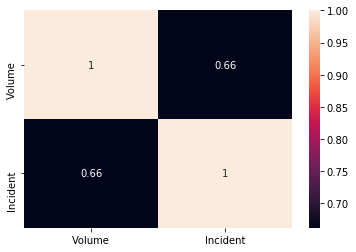

In [17]:
corr = stats_per_grid[['Volume','Incident']].corr()
sns.heatmap(corr, annot =True)


**Spearman Correlation between grid data**

In [18]:
temp = stats_per_grid.corr(method='spearman')
temp

,Grid_Location,Camera,Signal,Speed,Volume,Incident,Sign,Temp (C),Visibility (km)
Grid_Location,1.000000,0.095359,0.013270,-0.147166,-0.213243,-0.006741,0.004299,NaN,NaN
Camera,0.095359,1.000000,0.790989,0.033679,0.479390,0.435741,0.697308,NaN,NaN
Signal,0.013270,0.790989,1.000000,-0.004018,0.541730,0.510779,0.918836,NaN,NaN
Speed,-0.147166,0.033679,-0.004018,1.000000,0.289051,0.267016,-0.069820,NaN,NaN
Volume,-0.213243,0.479390,0.541730,0.289051,1.000000,0.597935,0.482444,NaN,NaN
Incident,-0.006741,0.435741,0.510779,0.267016,0.597935,1.000000,0.456521,NaN,NaN
Sign,0.004299,0.697308,0.918836,-0.069820,0.482444,0.456521,1.000000,NaN,NaN
Temp (C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Visibility (km),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


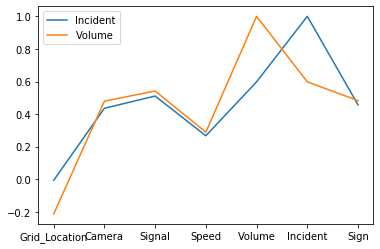

In [19]:
temp[['Incident','Volume']].plot()

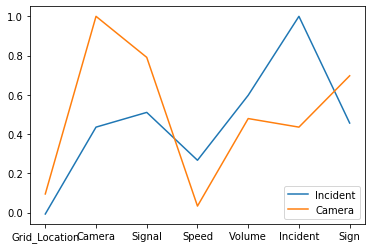

In [20]:
temp[['Incident','Camera']].plot()

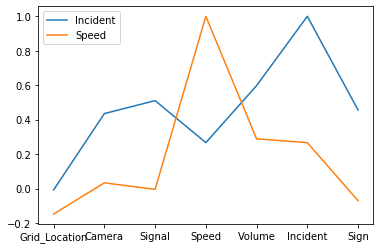

In [21]:
temp[['Incident','Speed']].plot()

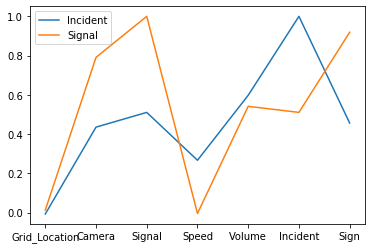

In [22]:
temp[['Incident','Signal']].plot()

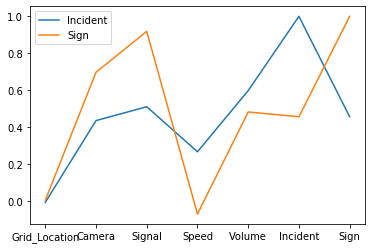

In [23]:
temp[['Incident','Sign']].plot()

## Data interpretation 

**Plot 1: The number of incidents vs the number of Cameras**

This plot shows us the relation between the total number of cameras and the average number of incidents that occured in the City of Calgary. Clearly the data shows as the number of camera increases, the average number of incidents decreases.

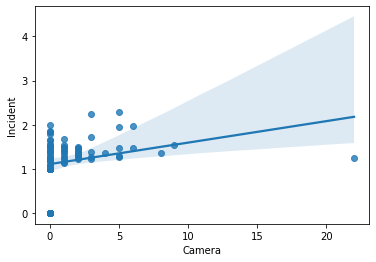

In [24]:
sns.regplot(x="Camera", y="Incident", data=stats_per_grid)

**Plot 2: The average number of incidents vs volume of cars**
    
This plot shows us the relation between the volume of cars and the average number of incidents that occured in the City of Calgary. We can observe from the data that the number of cars has a direct affect on the number of incidents on the road. 

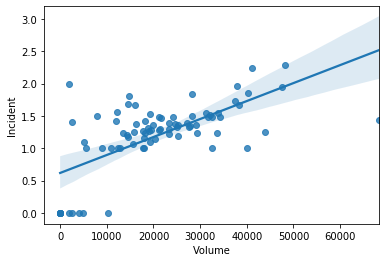

In [25]:
sns.regplot(x="Volume", y="Incident", data=stats_per_grid)

**Plot 3: The average number of incidents vs speed**

This plot shows us the relation between speed and the average number of incidents that occured in the City of Calgary.
The plot shoes the positive correlation between the average number of incident and the speed. As the speed increases, the average number of incidents increases as well. 

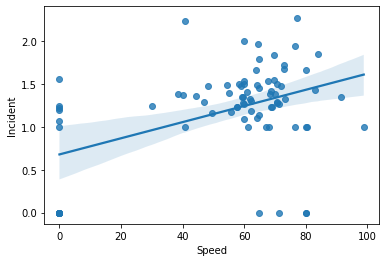

In [26]:
sns.regplot(x="Speed", y="Incident", data=stats_per_grid)

**Plot 4: The average number of incidents vs signs**

This plot shows us the relation between number of signs and the average number of incidents that occured in the City of Calgary. The data shows that the number of signs has an overall effect on the average number of incidents. The average is number of incidents is kept constants at approx 1.5 incidents in areas where there are a lot of signs.

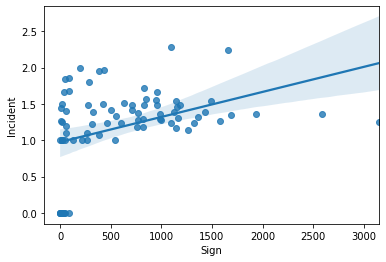

In [27]:
sns.regplot(x="Sign", y="Incident", data=stats_per_grid)

**Plot 5: The average number of incidents vs signals**

This plot shows us the relation between number of signals and the average number of incidents that occured in the City of Calgary. Signals have little effect on the number of incidents.

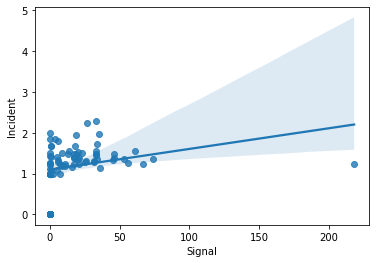

In [28]:
sns.regplot(x="Signal", y="Incident", data=stats_per_grid)

In [31]:
m

In [33]:
draw_stats.get_heatMap()

In [34]:
draw_stats.get_StatsMap()

In [ ]:
draw_stats.g